## Importing Packages

In [49]:
#Data management
import pandas as pd
import numpy as np
np.random.seed(0)
#from pandas_profiling import ProfileReport

#TextBlob Features
from textblob import TextBlob

#Plotting
import matplotlib.pyplot as plt

#SciKit-Learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#nltk
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

#Tensorflow / Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#Test
from collections import Counter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Importing Data

In [50]:
#Training Data
path = "/content/twitter_training.csv"
train_df = pd.read_csv(path, names=["Tweet_ID", "Entity", "Sentiment", "Tweet_Content"])

#Test Data (Not to be used until the full model has been trained)
test_path = "/content/twitter_validation.csv"
test_df = pd.read_csv(test_path, names=["Tweet_ID", "Entity", "Sentiment", "Tweet_Content"])

## Dropping NA Values

In [51]:
train_df = train_df.dropna()
test_df = test_df.dropna()

In [52]:
train_df.shape

(73996, 4)

## Subsetting Data

In [53]:
df = train_df.sample(frac=0.1)
df.reset_index(drop=True, inplace=True)

## Data Exploration

In [54]:
#See overall information about the data frame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7400 entries, 0 to 7399
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet_ID       7400 non-null   int64 
 1   Entity         7400 non-null   object
 2   Sentiment      7400 non-null   object
 3   Tweet_Content  7400 non-null   object
dtypes: int64(1), object(3)
memory usage: 231.4+ KB


In [55]:
#Display a few entries
df.head()

,Tweet_ID,Entity,Sentiment,Tweet_Content
0,2535,Borderlands,Negative,@ Borderlands. Can we get a big fix please? I'...
1,11073,TomClancysGhostRecon,Negative,@GhostRecon You call 1.1.0 an update. You're h...
2,3024,Dota2,Neutral,I'm excited to watch the EU's closed qualifyin...
3,6719,Fortnite,Negative,"anyways but my fortnite here,, im annoyed."
4,1533,Battlefield,Negative,Collateral with the revolver is so satisfying....


## Checking Balance of the Data in Output Categories

<BarContainer object of 4 artists>

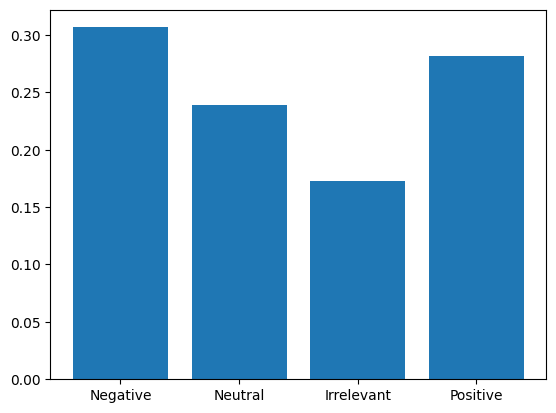

In [56]:
#Checking balance of target classes
sentiments = list(df["Sentiment"].unique())

sentiment_nums = [len(df[df["Sentiment"] == sentiment]) / len(df) for sentiment in sentiments]

plt.bar(sentiments, sentiment_nums)

## Labels to Indexes (and Back Again)


In [57]:
#Define the indexing for each possible label in a dictionary
class_to_index = {"Neutral":0, "Irrelevant":1, "Negative":2, "Positive": 3}

#Creates a reverse dictionary
index_to_class = dict((v,k) for k, v in class_to_index.items())

#Creates lambda functions, applying the appropriate dictionary
names_to_ids = lambda n: np.array([class_to_index.get(x) for x in n])
ids_to_names = lambda n: np.array([index_to_class.get(x) for x in n])

In [58]:
#Test each function
print(names_to_ids(["Positive", "Negative", "Irrelevant", "Neutral"]))
print(ids_to_names([0,1,2,3]))

[3 2 1 0]
['Neutral' 'Irrelevant' 'Negative' 'Positive']


In [59]:
#Convert the "Sentiment" column into indexes
df["Sentiment"] = names_to_ids(df["Sentiment"])

In [60]:
df.head()

,Tweet_ID,Entity,Sentiment,Tweet_Content
0,2535,Borderlands,2,@ Borderlands. Can we get a big fix please? I'...
1,11073,TomClancysGhostRecon,2,@GhostRecon You call 1.1.0 an update. You're h...
2,3024,Dota2,0,I'm excited to watch the EU's closed qualifyin...
3,6719,Fortnite,2,"anyways but my fortnite here,, im annoyed."
4,1533,Battlefield,2,Collateral with the revolver is so satisfying....


## NLP Data Enrichment

In [61]:
def remove_stopwords(ls):
    #Lemmatises, then removes stop words
    ls = [lemmatiser.lemmatize(word) for word in ls if word not in (stop_english) and (word.isalpha())]

    #Joins the words back into a single string
    ls = " ".join(ls)
    return ls

#Splits each string into a list of words
df["Tweet_Content_Split"] = df["Tweet_Content"].apply(word_tokenize)

#Applies the above function to each entry in the DataFrame
lemmatiser = WordNetLemmatizer()
stop_english = Counter(stopwords.words()) #Here we use a Counter dictionary on the cached
                                          # list of stop words for a huge speed-up
df["Tweet_Content_Split"] = df["Tweet_Content_Split"].apply(remove_stopwords)

In [62]:
df.head()

,Tweet_ID,Entity,Sentiment,Tweet_Content,Tweet_Content_Split
0,2535,Borderlands,2,@ Borderlands. Can we get a big fix please? I'...,Borderlands Can big fix I reset entire factory...
1,11073,TomClancysGhostRecon,2,@GhostRecon You call 1.1.0 an update. You're h...,GhostRecon You call update You laugh stay conn...
2,3024,Dota2,0,I'm excited to watch the EU's closed qualifyin...,I excited watch EU closed qualifying match EU ...
3,6719,Fortnite,2,"anyways but my fortnite here,, im annoyed.",fortnite annoyed
4,1533,Battlefield,2,Collateral with the revolver is so satisfying....,Collateral revolver unk


## Tokenisation

In [63]:
#Define the Tokeniser
tokeniser = Tokenizer(num_words=10000, lower=True)

#Create the corpus by finding the most common
tokeniser.fit_on_texts(df["Tweet_Content_Split"])

In [64]:
#Tokenise our column of edited Tweet content
tweet_tokens = tokeniser.texts_to_sequences(list(df["Tweet_Content_Split"]))

In [65]:
#Pad these sequences to make them the same length
tweet_tokens = pad_sequences(tweet_tokens, truncating = 'post', padding='post', maxlen=50)

In [66]:
tweet_tokens.shape

(7400, 50)

## Final Data Preparation

In [67]:
#Remove dependent variable
y = df["Sentiment"]

#Drop all non-useful columns
df = pd.DataFrame(tweet_tokens)

In [68]:
#Display final shape
df.shape

(7400, 50)

## Test-Train Split

In [69]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=1)

In [70]:
model = tf.keras.models.Sequential([
tf.keras.layers.Embedding(10000,16,input_length=50),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
tf.keras.layers.Dense(4, activation='softmax')
])
model.compile(
     loss='sparse_categorical_crossentropy',
     optimizer='adam',
     metrics=['accuracy']
)

## Training

In [71]:
h = model.fit(
     X_train, y_train,
     validation_data=(X_test, y_test),
     epochs=15,
     callbacks=[tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)]
)

Epoch 1/15
185/185 [==============================] - 21s 74ms/step - loss: 1.3467 - accuracy: 0.3419 - val_loss: 1.2439 - val_accuracy: 0.4777
Epoch 2/15
185/185 [==============================] - 11s 62ms/step - loss: 1.0041 - accuracy: 0.5894 - val_loss: 1.0860 - val_accuracy: 0.5554
Epoch 3/15
185/185 [==============================] - 14s 77ms/step - loss: 0.6517 - accuracy: 0.7627 - val_loss: 1.1782 - val_accuracy: 0.5473
Epoch 4/15
185/185 [==============================] - 11s 58ms/step - loss: 0.4640 - accuracy: 0.8404 - val_loss: 1.1697 - val_accuracy: 0.5642
Epoch 5/15
185/185 [==============================] - 11s 60ms/step - loss: 0.3396 - accuracy: 0.8838 - val_loss: 1.4243 - val_accuracy: 0.5595
Epoch 6/15
185/185 [==============================] - 12s 66ms/step - loss: 0.2663 - accuracy: 0.9083 - val_loss: 1.5776 - val_accuracy: 0.5622
Epoch 7/15
185/185 [==============================] - 15s 79ms/step - loss: 0.2185 - accuracy: 0.9240 - val_loss: 1.6483 - val_accuracy:

## Model Evaluation


In [72]:
#Generate predictions
y_pred = np.argmax(model.predict(X_test), axis=1)

#Assign labels to predictions and test data
y_pred_labels = ids_to_names(y_pred)
y_test_labels = ids_to_names(y_test)

47/47 [==============================] - 3s 16ms/step


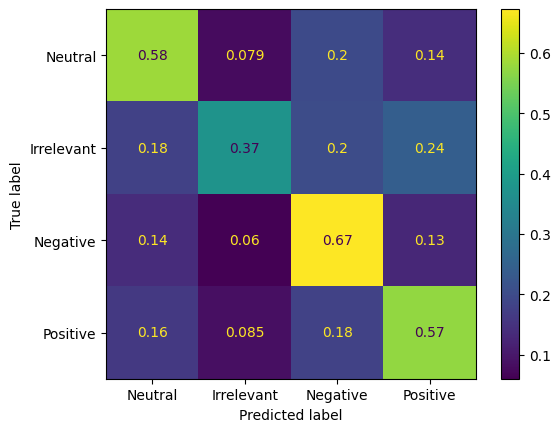

In [73]:
y_unique = list(set(y_test_labels))
cm = confusion_matrix(y_test_labels, y_pred_labels, labels = y_unique, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_unique)
disp.plot()

## Training with Full Dataset

In [74]:
#Use the full dataset!
df = train_df

## Basic Data Enrichment

In [75]:
#Convert the "Sentiment" column into indexes

##Train
df["Sentiment"] = names_to_ids(df["Sentiment"])
y = df["Sentiment"]

##Test
test_df["Sentiment"] = names_to_ids(test_df["Sentiment"])
y_test = test_df["Sentiment"]

## NLP Data Enrichment

In [76]:
#Removing stopwords and lemmatising

##Train
#Splits each string into a list of words
df["Tweet_Content_Split"] = df["Tweet_Content"].apply(word_tokenize)

#Applies the above function to each entry in the DataFrame
lemmatiser = WordNetLemmatizer()
stop_english = Counter(stopwords.words()) #Here we use a Counter dictionary on the cached
                                          # list of stop words for a huge speed-up
df["Tweet_Content_Split"] = df["Tweet_Content_Split"].apply(remove_stopwords)

##Test
test_df["Tweet_Content_Split"] = test_df["Tweet_Content"].apply(word_tokenize)

test_df["Tweet_Content_Split"] = test_df["Tweet_Content_Split"].apply(remove_stopwords)

In [77]:
#Tokenisation

#Define the Tokeniser
tokeniser = Tokenizer(num_words=10000, lower=True)

#Create the corpus by finding the most common
tokeniser.fit_on_texts(df["Tweet_Content_Split"])

##Train
#Tokenise our column of edited Tweet content
tweet_tokens = tokeniser.texts_to_sequences(list(df["Tweet_Content_Split"]))
tweet_tokens = pad_sequences(tweet_tokens, truncating = 'post', padding='post', maxlen=50)

##Test
#Tokenise our column of edited Tweet content
tweet_tokens_test = tokeniser.texts_to_matrix(list(test_df["Tweet_Content_Split"]))
tweet_tokens_test = pad_sequences(tweet_tokens_test, truncating = 'post', padding='post', maxlen=50)

In [78]:
#Final prep

##Train
#Drop all non-useful columns
full_df = pd.DataFrame(tweet_tokens)

##Test
full_test_df = pd.DataFrame(tweet_tokens_test)

## Model Definition and Training

This time, we train with all of the available training data

In [79]:
#Original
model = tf.keras.models.Sequential([
tf.keras.layers.Embedding(10000,16,input_length=50),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(
     loss='sparse_categorical_crossentropy',
     optimizer='adam',
     metrics=['accuracy']
)

In [80]:
h = model.fit(
     full_df, y,
     validation_data=(full_test_df, y_test),
     epochs=30,
     callbacks=[tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)]
)

Epoch 1/30
2313/2313 [==============================] - 177s 73ms/step - loss: 0.9362 - accuracy: 0.6147 - val_loss: 1.4084 - val_accuracy: 0.2770
Epoch 2/30
2313/2313 [==============================] - 170s 74ms/step - loss: 0.5560 - accuracy: 0.7922 - val_loss: 1.3989 - val_accuracy: 0.2880
Epoch 3/30
2313/2313 [==============================] - 168s 73ms/step - loss: 0.4257 - accuracy: 0.8408 - val_loss: 1.3712 - val_accuracy: 0.3180
Epoch 4/30
2313/2313 [==============================] - 169s 73ms/step - loss: 0.3569 - accuracy: 0.8655 - val_loss: 1.3896 - val_accuracy: 0.2620
Epoch 5/30
2313/2313 [==============================] - 166s 72ms/step - loss: 0.3154 - accuracy: 0.8806 - val_loss: 1.3695 - val_accuracy: 0.2850
Epoch 6/30
2313/2313 [==============================] - 164s 71ms/step - loss: 0.2847 - accuracy: 0.8910 - val_loss: 1.3668 - val_accuracy: 0.3090
Epoch 7/30
2313/2313 [==============================] - 168s 73ms/step - loss: 0.2601 - accuracy: 0.8999 - val_loss: 1

## Final Model Evaluation

In [81]:
#Generate predictions
y_pred = np.argmax(model.predict(full_test_df), axis=1)

#Assign labels to predictions and test data
y_pred_labels = ids_to_names(y_pred)
y_test_labels = ids_to_names(y_test)

32/32 [==============================] - 3s 25ms/step


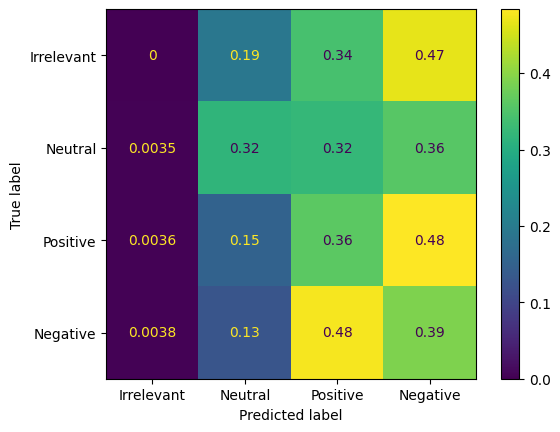

In [82]:
y_unique = list(set(y_test_labels))
cm = confusion_matrix(y_test_labels, y_pred_labels, labels = y_unique, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_unique)
disp.plot()

In [83]:
#To see the final accuracy
accuracy_score(y_test, y_pred)

0.294